# Comparison of DE genes in genome-wide screens for different cell types

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import pandas as pd
import numpy as np
import scanpy as sc
import anndata
import zarr
import scipy
import pertpy
# import rapids_singlecell

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/

## Load MASH DE results
Generated in `K562_DEseq2.ipynb`

In [3]:
all_res_df = pd.read_parquet('/mnt/oak/users/emma/data/GWT/CD4iR1_Psomagen/MASH_comparison_results.parquet')

In [4]:
split_test_df = all_res_df.test.str.split("_", expand=True).rename(columns={0: "target_contrast", 1: "gene_name"})

In [5]:
all_res_df = pd.concat([all_res_df, split_test_df], axis=1)

In [6]:
all_res_df['cell_type'] = np.where(all_res_df['index'] == 'log_fc', 'K562', all_res_df['index'])
all_res_df = all_res_df.drop(['model_key', 'index'], axis=1)

In [ ]:
# sns.scatterplot(x=all_res_df['Bhat'], y=all_res_df['PosteriorMean'])

<Axes: xlabel='Bhat', ylabel='PosteriorMean'>

### Visualize overlap in DE genes

In [9]:
signif_res_df = all_res_df[all_res_df['lfsr'] < 0.05]

In [31]:
wide_signif_res_df = signif_res_df.pivot(columns='cell_type', index=['target_contrast', 'gene_name'], values='PosteriorMean')

/tmp/ipykernel_835246/2193215201.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=12)


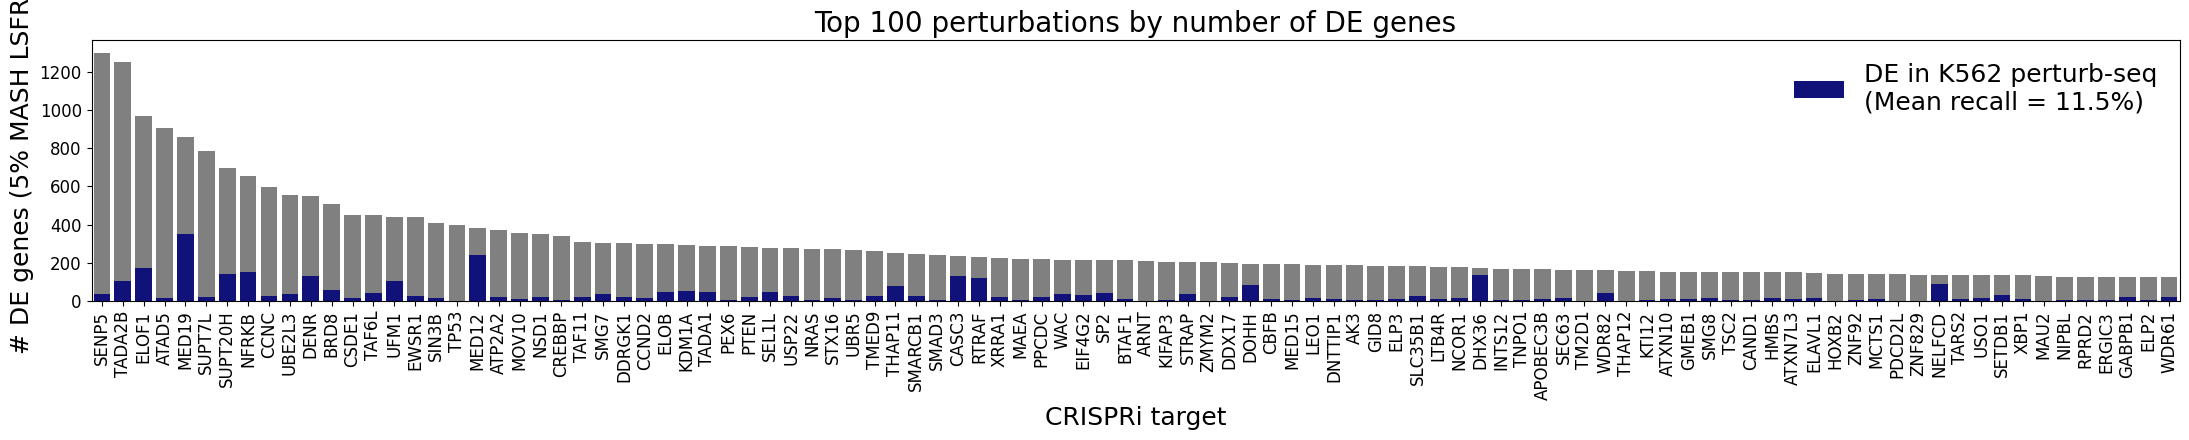

/tmp/ipykernel_835246/2193215201.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=12)


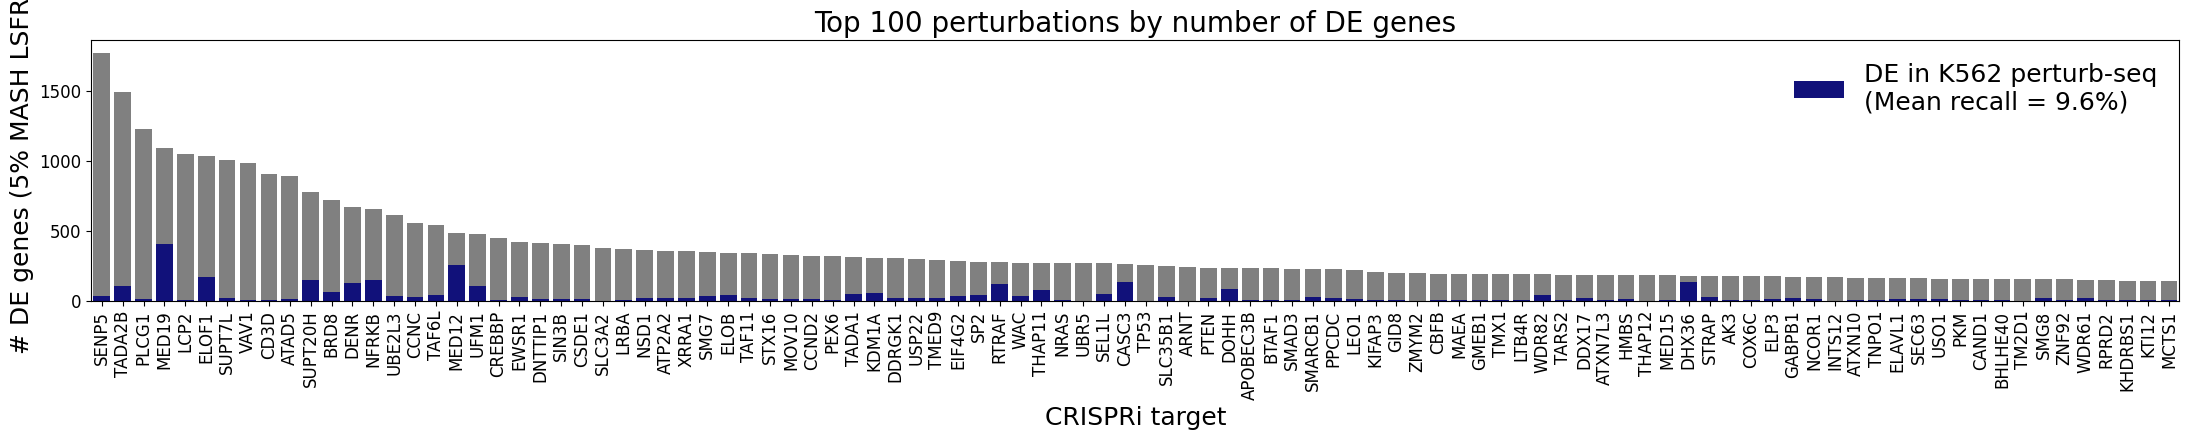

In [33]:
tcells_de_compare_dict = {}
for c in ['Rest', 'Stim8hr']:
    signif_df = (wide_signif_res_df[['K562', c]]
        .groupby('target_contrast')
        .apply(lambda x: pd.Series({
            'K562_repl': ((~x['K562'].isna()) & (~x[c].isna())).sum(),
            'n_signif': (~x[c].isna()).sum()
        })))
    signif_df = signif_df.sort_values('n_signif', ascending=False)

    # Take top 100 perturbations
    pl_signif_df = signif_df.head(100)

    # Create single figure
    fig, ax = plt.subplots(figsize=(22, 4.5))

    # Plot bars
    sns.barplot(data=pl_signif_df, x='target_contrast', y='n_signif', ax=ax, color='grey')
    sns.barplot(data=pl_signif_df, x='target_contrast', y='K562_repl', ax=ax, color='darkblue', 
                label=f'DE in K562 perturb-seq\n(Mean recall = {np.round(np.mean(pl_signif_df["K562_repl"]/pl_signif_df["n_signif"]) * 100, 1)}%)')

    # Customize plot
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=12)
    ax.set_ylabel('# DE genes (5% MASH LSFR)', fontsize=18)
    ax.set_xlabel('CRISPRi target', fontsize=18)
    ax.tick_params(axis='y', labelsize=12)
    ax.legend(frameon=False, fontsize=18)

    plt.title('Top 100 perturbations by number of DE genes', fontsize=20)
    plt.tight_layout()
    plt.show()

## Compare effect size

In [172]:
# Keep targets with at least some significant effect in Replogle
keep_targets = signif_res_df[signif_res_df.cell_type == 'K562']['target_contrast'].unique()
k562_de_compare = all_res_df[all_res_df.cell_type == 'K562'].pivot(columns='target_contrast', index='gene_name', values="PosteriorMean")
rest_de_compare = all_res_df[all_res_df.cell_type == 'Rest'].pivot(columns='target_contrast', index='gene_name', values="PosteriorMean")
stim_de_compare = all_res_df[all_res_df.cell_type == 'Stim8hr'].pivot(columns='target_contrast', index='gene_name', values="PosteriorMean")

In [176]:
k562_de_compare = k562_de_compare.mask(k562_de_compare.index.values[:, None] == k562_de_compare.columns.values).fillna(0)
rest_de_compare = rest_de_compare.mask(rest_de_compare.index.values[:, None] == rest_de_compare.columns.values).fillna(0)
stim_de_compare = stim_de_compare.mask(k562_de_compare.index.values[:, None] == stim_de_compare.columns.values).fillna(0)

In [177]:
# Define the comparisons we want to make
comparisons = [
    ('K562_vs_Rest', k562_de_compare, rest_de_compare),
    ('K562_vs_Stim', k562_de_compare, stim_de_compare),
    ('Stim_vs_Rest', stim_de_compare, rest_de_compare)
]

# Create separate DataFrames for each comparison
comparison_results = {}

for comparison_name, df1, df2 in comparisons:
    # Initialize DataFrame for this comparison
    results_df = pd.DataFrame(columns=['Perturbation', 'pearson_r', 'pearson_pval', 
                                      'random_r1', 'random_r2', 'random_r3'])
    
    # Iterate through common perturbations
    for perturb in df1.columns:
        values1 = df1[perturb]
        values2 = df2[perturb]
        
        # Calculate correlation for the same perturbation
        corr = scipy.stats.pearsonr(values1, values2)
        
        # Calculate random correlations (shuffling column labels 3 times)
        random_rs = []
        for _ in range(3):
            random_perturb = np.random.choice(df1.columns)
            random_values = df2[random_perturb]
            random_corr = scipy.stats.pearsonr(values1, random_values)
            random_rs.append(random_corr.statistic)
        
        # Add to results DataFrame
        new_row = pd.DataFrame({
            'Perturbation': [perturb],
            'pearson_r': [corr.statistic],
            'pearson_pval': [corr.pvalue],
            'random_r1': [random_rs[0]],
            'random_r2': [random_rs[1]],
            'random_r3': [random_rs[2]]
        })
        results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    # Sort by correlation
    results_df = results_df.sort_values('pearson_r', ascending=False)
    
    # Store in our dictionary
    comparison_results[comparison_name] = results_df

In [179]:
correlation_results = pd.concat([v.assign(comparison=k) for k,v in comparison_results.items()])
correlation_results

,Perturbation,pearson_r,pearson_pval,random_r1,random_r2,random_r3,comparison
1881,SLC30A1,0.912449,0.000000e+00,-0.002662,-0.002765,0.005752,K562_vs_Rest
1924,SMG7,0.885274,0.000000e+00,-0.003642,-0.041208,0.031096,K562_vs_Rest
973,INTS12,0.875763,0.000000e+00,-0.004480,0.009739,0.024270,K562_vs_Rest
674,ELP1,0.868894,0.000000e+00,0.013329,0.019365,-0.000626,K562_vs_Rest
1243,MTA2,0.853250,0.000000e+00,0.006726,0.031456,0.017433,K562_vs_Rest
...,...,...,...,...,...,...,...
1352,NPC1,0.418215,1.233055e-260,-0.003279,0.024368,0.009317,Stim_vs_Rest
1080,LCP2,0.399785,2.732450e-236,-0.085693,0.010547,0.056295,Stim_vs_Rest
1098,LRBA,0.394199,3.283758e-229,0.001688,0.029292,0.023555,Stim_vs_Rest
2291,UBE2Q1,0.361456,2.215292e-190,0.010845,-0.001946,-0.057067,Stim_vs_Rest


In [173]:
correlation_results

,Perturbation,pearson_r,pearson_pval,random_r1,random_r2,random_r3,comparison
2475,ZNF142,0.809609,0.0,NaN,NaN,NaN,K562_vs_Rest
277,C2orf76,0.708903,0.0,NaN,NaN,-0.028703,K562_vs_Rest
1079,LCMT2,0.689640,0.0,NaN,NaN,NaN,K562_vs_Rest
1912,SMAD3,0.683709,0.0,NaN,NaN,NaN,K562_vs_Rest
2388,WDR61,0.674137,0.0,NaN,NaN,0.008068,K562_vs_Rest
...,...,...,...,...,...,...,...
2547,ZNF780A,NaN,NaN,NaN,NaN,NaN,Stim_vs_Rest
2550,ZNF92,NaN,NaN,NaN,NaN,NaN,Stim_vs_Rest
2552,ZSWIM7,NaN,NaN,NaN,NaN,NaN,Stim_vs_Rest
2553,ZUP1,NaN,NaN,NaN,NaN,NaN,Stim_vs_Rest


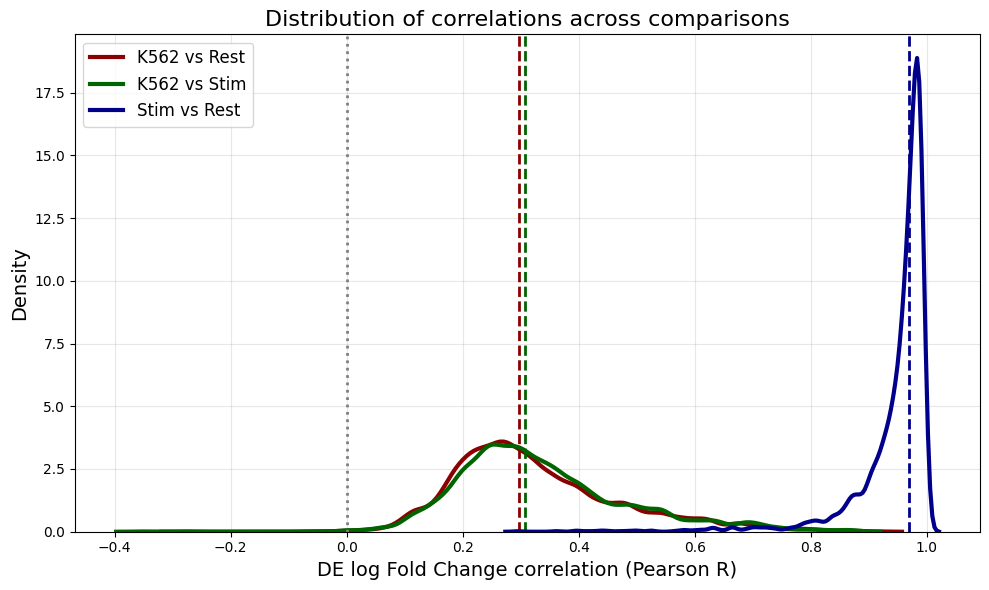

In [180]:
correlation_results = pd.concat([v.assign(comparison=k) for k,v in comparison_results.items()])

# Create single density plot
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for each comparison
comparison_colors = {
    'K562_vs_Rest': '#8B0000',    # Dark red
    'K562_vs_Stim': '#006400',    # Dark green 
    'Stim_vs_Rest': '#00008B'     # Dark blue
}

# Plot random distributions for all comparisons
for comparison in ['K562_vs_Rest', 'K562_vs_Stim', 'Stim_vs_Rest']:
    mask = correlation_results['comparison'] == comparison
    # for col in ['random_r1', 'random_r2', 'random_r3']:
    #     sns.kdeplot(
    #         data=correlation_results[mask][col],
    #         ax=ax,
    #         color='#7f7f7f',
    #         linewidth=1,
    #         alpha=0.3,
    #         label='_nolegend_',  # Hide from legend
    #         bw_adjust=0.5,
    #         common_norm=True
    #     )

# Plot main distributions for each comparison
for comparison, color in comparison_colors.items():
    mask = correlation_results['comparison'] == comparison
    sns.kdeplot(
        data=correlation_results[mask]['pearson_r'],
        ax=ax,
        color=color,
        linewidth=3,
        label=comparison.replace('_', ' '),
        bw_adjust=0.5,
        common_norm=False
    )
    
    # Add vertical line for median
    median = correlation_results[mask]['pearson_r'].median()
    ax.axvline(median, color=color, linestyle='dashed', linewidth=2)

# Add zero line
ax.axvline(0, color='#7f7f7f', linestyle='dotted', linewidth=2)

# Styling
ax.set_xlabel('DE log Fold Change correlation (Pearson R)', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.set_title('Distribution of correlations across comparisons', fontsize=16)
ax.legend(fontsize=12)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

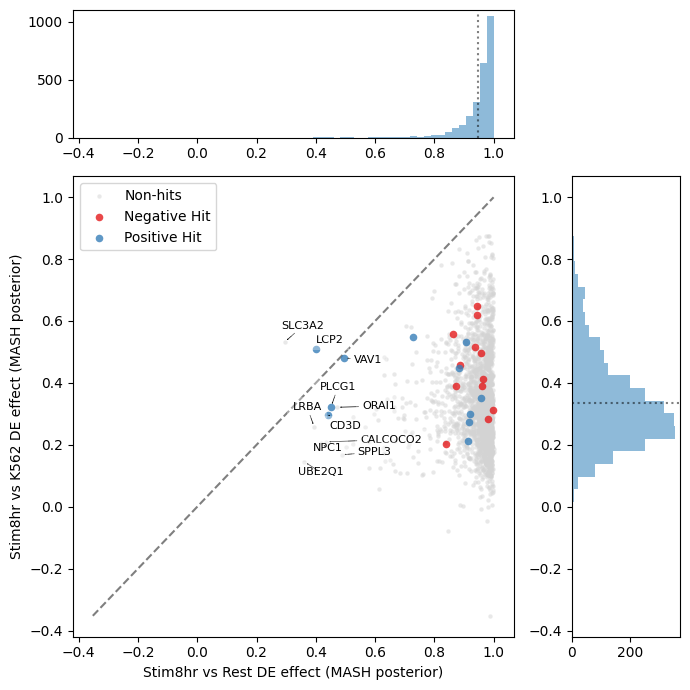

In [182]:
## Load IL2 hits
schmidt_crispri = pd.read_excel('../../../metadata/Schmidt2022_hits_Supplementary_table_2.xlsx', usecols=range(10))
schmidt_crispri_hits = schmidt_crispri[schmidt_crispri['Hit'] & (schmidt_crispri['CRISPRa_or_i'] == 'CRISPRi') & (schmidt_crispri['CD4_or_CD8'] == 'CD4')]

# Create dictionary where key is hit type and values are lists of genes
hit_type_dict = {}
for hit_type in schmidt_crispri_hits['Hit_Type'].unique():
    hit_type_dict[hit_type] = schmidt_crispri_hits[schmidt_crispri_hits['Hit_Type'] == hit_type]['Gene'].tolist()

pl_df = correlation_results.pivot(columns='comparison', index='Perturbation', values='pearson_r')

# Create figure with gridspec for main scatter plot and marginal distributions
fig = plt.figure(figsize=(7, 7))
gs = fig.add_gridspec(4, 4)  # Increase grid divisions for finer control
ax_main = fig.add_subplot(gs[1:, :-1])
ax_right = fig.add_subplot(gs[1:, -1], sharey=ax_main)
ax_top = fig.add_subplot(gs[0, :-1], sharex=ax_main)  # Reduced height by using only 1/4 of vertical space

# Create color palette for hit types
hit_colors = {
    'Negative Hit': '#e41a1c',
    'Positive Hit': '#377eb8',
    # 'Both': '#4daf4a'
}

# Plot non-hit genes in gray first
non_hits = pl_df.index[~pl_df.index.isin([gene for genes in hit_type_dict.values() for gene in genes])]
sns.scatterplot(data=pl_df.loc[non_hits], x='Stim_vs_Rest', y='K562_vs_Stim', 
                color='lightgray', s=10, linewidth=0, alpha=0.5, ax=ax_main, label='Non-hits')

# Plot hits with different colors
for hit_type, genes in hit_type_dict.items():
    hit_genes = [g for g in genes if g in pl_df.index]
    if hit_genes:
        sns.scatterplot(data=pl_df.loc[hit_genes], x='Stim_vs_Rest', y='K562_vs_Stim',
                       color=hit_colors[hit_type], s=30, linewidth=0, alpha=0.8, 
                       ax=ax_main, label=hit_type)

# Add diagonal line
lims = [
    min(pl_df['Stim_vs_Rest'].min(), pl_df['K562_vs_Stim'].min()),
    max(pl_df['Stim_vs_Rest'].max(), pl_df['K562_vs_Stim'].max())
]
ax_main.plot(lims, lims, 'k--', alpha=0.5, zorder=0)
ax_main.set_xlabel('Stim8hr vs Rest DE effect (MASH posterior)')
ax_main.set_ylabel('Stim8hr vs K562 DE effect (MASH posterior)')

# Annotate perturbations with low Stim_vs_Rest correlation using adjustText
from adjustText import adjust_text

low_corr_mask = pl_df['Stim_vs_Rest'] < 0.5
texts = []
for idx in pl_df[low_corr_mask].index:
    texts.append(ax_main.text(pl_df.loc[idx, 'Stim_vs_Rest'], 
                            pl_df.loc[idx, 'K562_vs_Stim'],
                            idx,
                            fontsize=8,
                            bbox=dict(facecolor='white', alpha=0.3, edgecolor='none')))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.5), ax=ax_main)

# Add marginal histograms
ax_top.hist(pl_df['Stim_vs_Rest'], bins=30, alpha=0.5)
ax_top.axvline(pl_df['Stim_vs_Rest'].mean(), color='black', linestyle=':', alpha=0.5)

ax_right.hist(pl_df['K562_vs_Stim'], bins=30, alpha=0.5, orientation='horizontal')
ax_right.axhline(pl_df['K562_vs_Stim'].mean(), color='black', linestyle=':', alpha=0.5)

# Remove redundant labels from marginal plots
ax_top.set_xlabel('')
ax_right.set_ylabel('')

plt.tight_layout()

/tmp/ipykernel_835246/1147890925.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pl_df['Perturbation'] = pd.Categorical(pl_df['Perturbation'], categories=order, ordered=True)


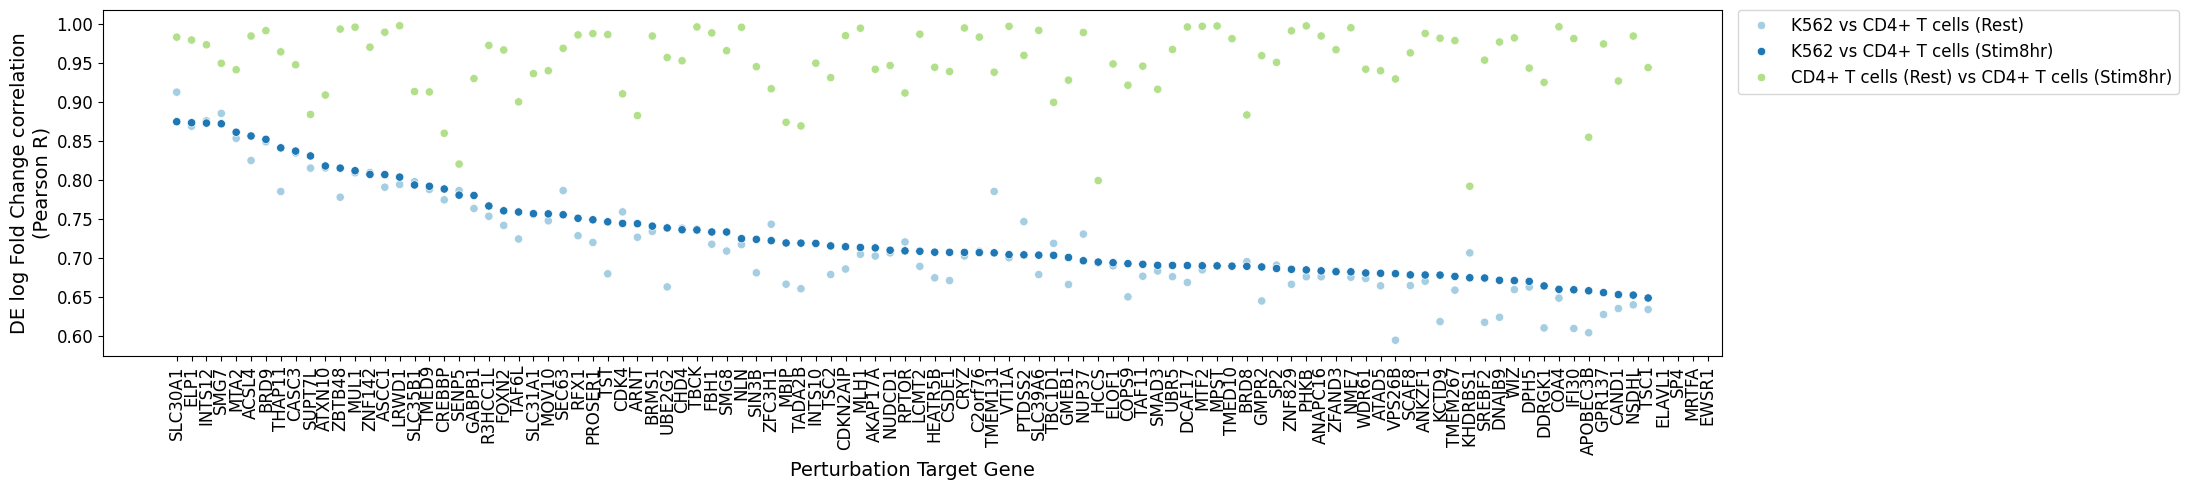

In [183]:
top_correlated_perturbs = correlation_results[correlation_results.comparison == 'K562_vs_Stim'].sort_values('pearson_r', ascending=False)[0:100]['Perturbation'].unique()
pl_df = correlation_results[correlation_results.Perturbation.isin(top_correlated_perturbs)]

# Create a categorical type with ordered categories based on correlation values
order = correlation_results[correlation_results.comparison == 'K562_vs_Stim'].sort_values('pearson_r', ascending=False)['Perturbation'].unique()
pl_df['Perturbation'] = pd.Categorical(pl_df['Perturbation'], categories=order, ordered=True)
plt.figure(figsize=(22, 5))
# Use a paired color palette for better distinction between comparison groups
# Make point size proportional to n_total_de_genes
ax = sns.scatterplot(data=pl_df, x='Perturbation', y='pearson_r', hue='comparison', 
                     palette='Paired')
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Perturbation Target Gene', fontsize=14)
plt.ylabel('DE log Fold Change correlation\n(Pearson R)', fontsize=14)
# Use the same labels as in the comparisons list
legend_labels = {
    'K562_vs_Rest': 'K562 vs CD4+ T cells (Rest)',
    'K562_vs_Stim': 'K562 vs CD4+ T cells (Stim8hr)',
    'Stim_vs_Rest': 'CD4+ T cells (Rest) vs CD4+ T cells (Stim8hr)'
}
handles, labels = ax.get_legend_handles_labels()
# Create cleaner legend labels by removing the comparison prefix
clean_labels = []
for label in labels:
    if label in legend_labels:
        clean_labels.append(legend_labels[label])
    elif label.startswith('n_total_de_genes'):
        clean_labels.append('Number of DE genes')
    else:
        clean_labels.append(label)

# Position legend outside but overlapping with the right side of the plot
ax.legend(handles=handles, labels=clean_labels, fontsize=12, 
          bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()

In [192]:
import gseapy as gp
correlated_gs = correlation_results[(correlation_results.comparison == 'K562_vs_Stim') & (correlation_results['pearson_r'] > 0.5)].Perturbation.unique()
correlated_gs = correlated_gs.tolist()
print(len(correlated_gs))
all_gs = correlation_results.Perturbation.unique().tolist()
print(len(all_gs))

def parse_gene_sets(filename):
   gene_sets = {}
   with open(filename, 'r') as f:
       for line in f:
           terms = line.strip().split('\t')
           gene_sets[terms[0]] = terms[2:]
   return gene_sets

OAKPATH = '/mnt/oak/'
KEGG_sets = parse_gene_sets(f'{OAKPATH}/users/emma/data//KEGG_2019_Human.txt')
GO_BP_sets = parse_gene_sets(f'{OAKPATH}/users/emma/data/GO_Biological_Process_2023.txt')
GENESETS = {**GO_BP_sets, **KEGG_sets}

# # run enrichr
enr = gp.enrichr(gene_list=correlated_gs,
                gene_sets=GENESETS,
                organism='Human', 
                cutoff=0.1,
                background=all_gs,
                outdir='results/test_enrichr/',
                no_plot=False
                )
enr.results[['Gene_set', 'Term', 'P-value', 'Adjusted P-value', 'Genes']].sort_values('Adjusted P-value')[0:40]



346
2555


,Gene_set,Term,P-value,Adjusted P-value,Genes
1307,gs_ind_0,Regulation Of DNA-templated Transcription (GO:...,0.000003,0.004730,ZBTB48;GMEB1;IKZF5;MTF2;DNMT3A;ZMYM2;CREBBP;MT...
384,gs_ind_0,Histone Acetylation (GO:0016573),0.000029,0.021657,USP22;TAF6L;CREBBP;TRRAP;MBIP;BRD8;SUPT20H;SUP...
390,gs_ind_0,Histone H3 Acetylation (GO:0043966),0.000073,0.021657,USP22;TAF6L;TRRAP;MBIP;SUPT20H;SUPT7L;TADA2B;A...
537,gs_ind_0,Monoubiquitinated Histone Deubiquitination (GO...,0.000066,0.021657,USP22;TAF6L;TRRAP;SUPT20H;SUPT7L;TADA2B;ATXN7L3
1515,gs_ind_0,Regulation Of Transcription By RNA Polymerase ...,0.000056,0.021657,ZBTB48;GMEB1;IKZF5;LIN37;DNMT3A;CREBBP;MTA2;CB...
538,gs_ind_0,Monoubiquitinated Histone H2A Deubiquitination...,0.000066,0.021657,USP22;TAF6L;TRRAP;SUPT20H;SUPT7L;TADA2B;ATXN7L3
905,gs_ind_0,Positive Regulation Of DNA-templated Transcrip...,0.000090,0.022951,ZBTB48;CREBBP;MTA2;NSD1;SCAF8;ATXN7L3;APEX1;NR...
1477,gs_ind_0,Regulation Of RNA Metabolic Process (GO:0051252),0.000181,0.040625,METTL18;RBM12;USP22;TAF6L;TRRAP;AKAP17A;SUPT20...
1301,gs_ind_0,Regulation Of DNA Metabolic Process (GO:0051052),0.000275,0.054730,ANKRD17;USP22;EHMT2;TAF6L;TRRAP;INO80C;INO80B;...
539,gs_ind_0,Monoubiquitinated Protein Deubiquitination (GO...,0.000339,0.055150,USP22;TAF6L;TRRAP;SUPT20H;SUPT7L;TADA2B;ATXN7L3


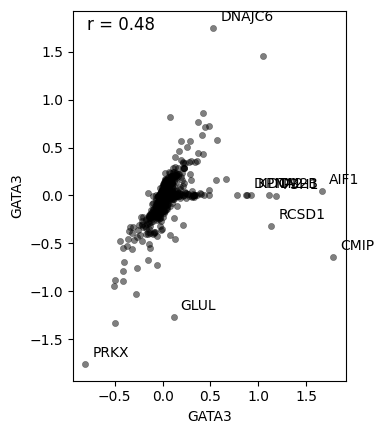

In [189]:
p = 'GATA3'

# Calculate correlation coefficient
corr = np.corrcoef(k562_de_compare[p], rest_de_compare[p])[0,1]

# Create scatter plot
ax = sns.scatterplot(x=k562_de_compare[p], y=rest_de_compare[p], 
                     s=20, color='black', edgecolor=None, alpha=0.5)

# Set equal aspect ratio
ax.set_aspect('equal')

# Add correlation coefficient annotation
ax.text(0.05, 0.95, f'r = {corr:.2f}', 
        transform=ax.transAxes, fontsize=12)

# Get indices of top/bottom genes to annotate
n_annotate = 10
sorted_idx = np.argsort(abs(k562_de_compare[p] - rest_de_compare[p]))
top_idx = sorted_idx[-n_annotate:]

# Add gene name annotations for top differences
for idx in top_idx:
    ax.annotate(k562_de_compare.index[idx],
                (k562_de_compare[p].iloc[idx], rest_de_compare[p].iloc[idx]),
                xytext=(5, 5), textcoords='offset points')

## Shared effects between perturbations

In [193]:
all_res_df['cell_type'] == 'Rest'

,test,Bhat,Shat,PosteriorMean,PosteriorSD,lfsr,target_contrast,gene_name,cell_type
0,ABRAXAS1_AAAS,0.254979,0.283443,0.012811,0.068877,0.651670,ABRAXAS1,AAAS,K562
1,ABRAXAS1_AACS,0.023432,0.506427,0.000574,0.074282,0.690984,ABRAXAS1,AACS,K562
2,ABRAXAS1_AAGAB,0.719737,0.276606,0.098921,0.188570,0.410950,ABRAXAS1,AAGAB,K562
3,ABRAXAS1_AAK1,0.279810,0.375801,0.012013,0.072499,0.646561,ABRAXAS1,AAK1,K562
4,ABRAXAS1_AAMDC,0.288553,0.301261,0.022102,0.083186,0.610164,ABRAXAS1,AAMDC,K562
...,...,...,...,...,...,...,...,...,...
4827415,ZRSR2_ZXDC,0.255147,0.154918,0.018750,0.050603,0.722793,ZRSR2,ZXDC,Stim8hr
4827416,ZRSR2_ZYG11A,0.568294,1.216380,0.000667,0.052811,0.843579,ZRSR2,ZYG11A,Stim8hr
4827417,ZRSR2_ZYG11B,-0.329087,0.291351,-0.026809,0.070846,0.697943,ZRSR2,ZYG11B,Stim8hr
4827418,ZRSR2_ZYX,-0.014696,0.171002,-0.010527,0.036569,0.775984,ZRSR2,ZYX,Stim8hr


In [206]:
# Restict to perturbations with at least 2 significant DE genes
cond = 'Stim8hr'
effect_stat = 'PosteriorMean'
signif_stat = 'lfsr'
signif_alpha = 0.05
filter_signif = False
mask_targets = True

res_df = all_res_df.copy()
res_df['significant'] = res_df[signif_stat] < signif_alpha

if mask_targets:
    res_df.loc[res_df['target_contrast'] == res_df['gene_name'], effect_stat] = 0
    res_df.loc[res_df['target_contrast'] == res_df['gene_name'], 'significant'] = False

if filter_signif:
    res_df = res_df[res_df['significant']]

In [ ]:
trans_effects_df = res_df.pivot(columns=['cell_type','target_contrast'], index='gene_name', values=effect_stat)
trans_effects_df = trans_effects_df.loc[:, np.abs(trans_effects_df).sum(0) > 1]
trans_effects_df.corr()

In [201]:
trans_effects_df = res_df.pivot(columns=['cell_type','target_contrast'], index='gene_name', values=effect_stat)
trans_effects_df = np.sign(trans_effects_df).fillna(0)
trans_effects_df.columns = [f"{cell}_{target}" for cell, target in trans_effects_df.columns]
trans_effects_df = trans_effects_df.loc[:, np.abs(trans_effects_df).sum(0) > 1]
trans_effects_df = trans_effects_df[trans_effects_df.sum(1) != 0]
trans_effects_df

,K562_ABRAXAS1,K562_ACAA1,K562_ACTR3,K562_ADK,K562_AGGF1,K562_AKAP9,K562_ALKBH2,K562_ANAPC7,K562_ANO6,K562_APRT,...,Stim8hr_ZC3H7A,Stim8hr_ZCCHC8,Stim8hr_ZFAND1,Stim8hr_ZFP82,Stim8hr_ZMYM3,Stim8hr_ZNF496,Stim8hr_ZNF586,Stim8hr_ZNF644,Stim8hr_ZNF92,Stim8hr_ZRSR2
gene_name,,,,,,,,,,,,,,,,,,,,,
AAAS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AACS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAGAB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAK1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAMDC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZWINT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZYG11A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZYG11B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Compute Jaccard similarity between perturbations 

In [202]:
# Compute intersection
pos_trans_effects_df = trans_effects_df.copy()
pos_trans_effects_df[pos_trans_effects_df < 0] = 0
neg_trans_effects_df = trans_effects_df.copy()
neg_trans_effects_df[neg_trans_effects_df > 0] = 0
shared_effects = pos_trans_effects_df.T.dot(pos_trans_effects_df) + neg_trans_effects_df.T.dot(neg_trans_effects_df)

# Compute size of union
n = shared_effects.shape[0]
total_genes = np.diag(shared_effects)
total_i = np.tile(total_genes.reshape(-1, 1), (1, n))
total_j = np.tile(total_genes.reshape(1, -1), (n, 1))
union = total_i + total_j - shared_effects

# Jaccard index (intersection / union)
similarity = np.divide(shared_effects.values, union, 
                            out=np.zeros_like(shared_effects, dtype=float), 
                            where=union!=0)

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


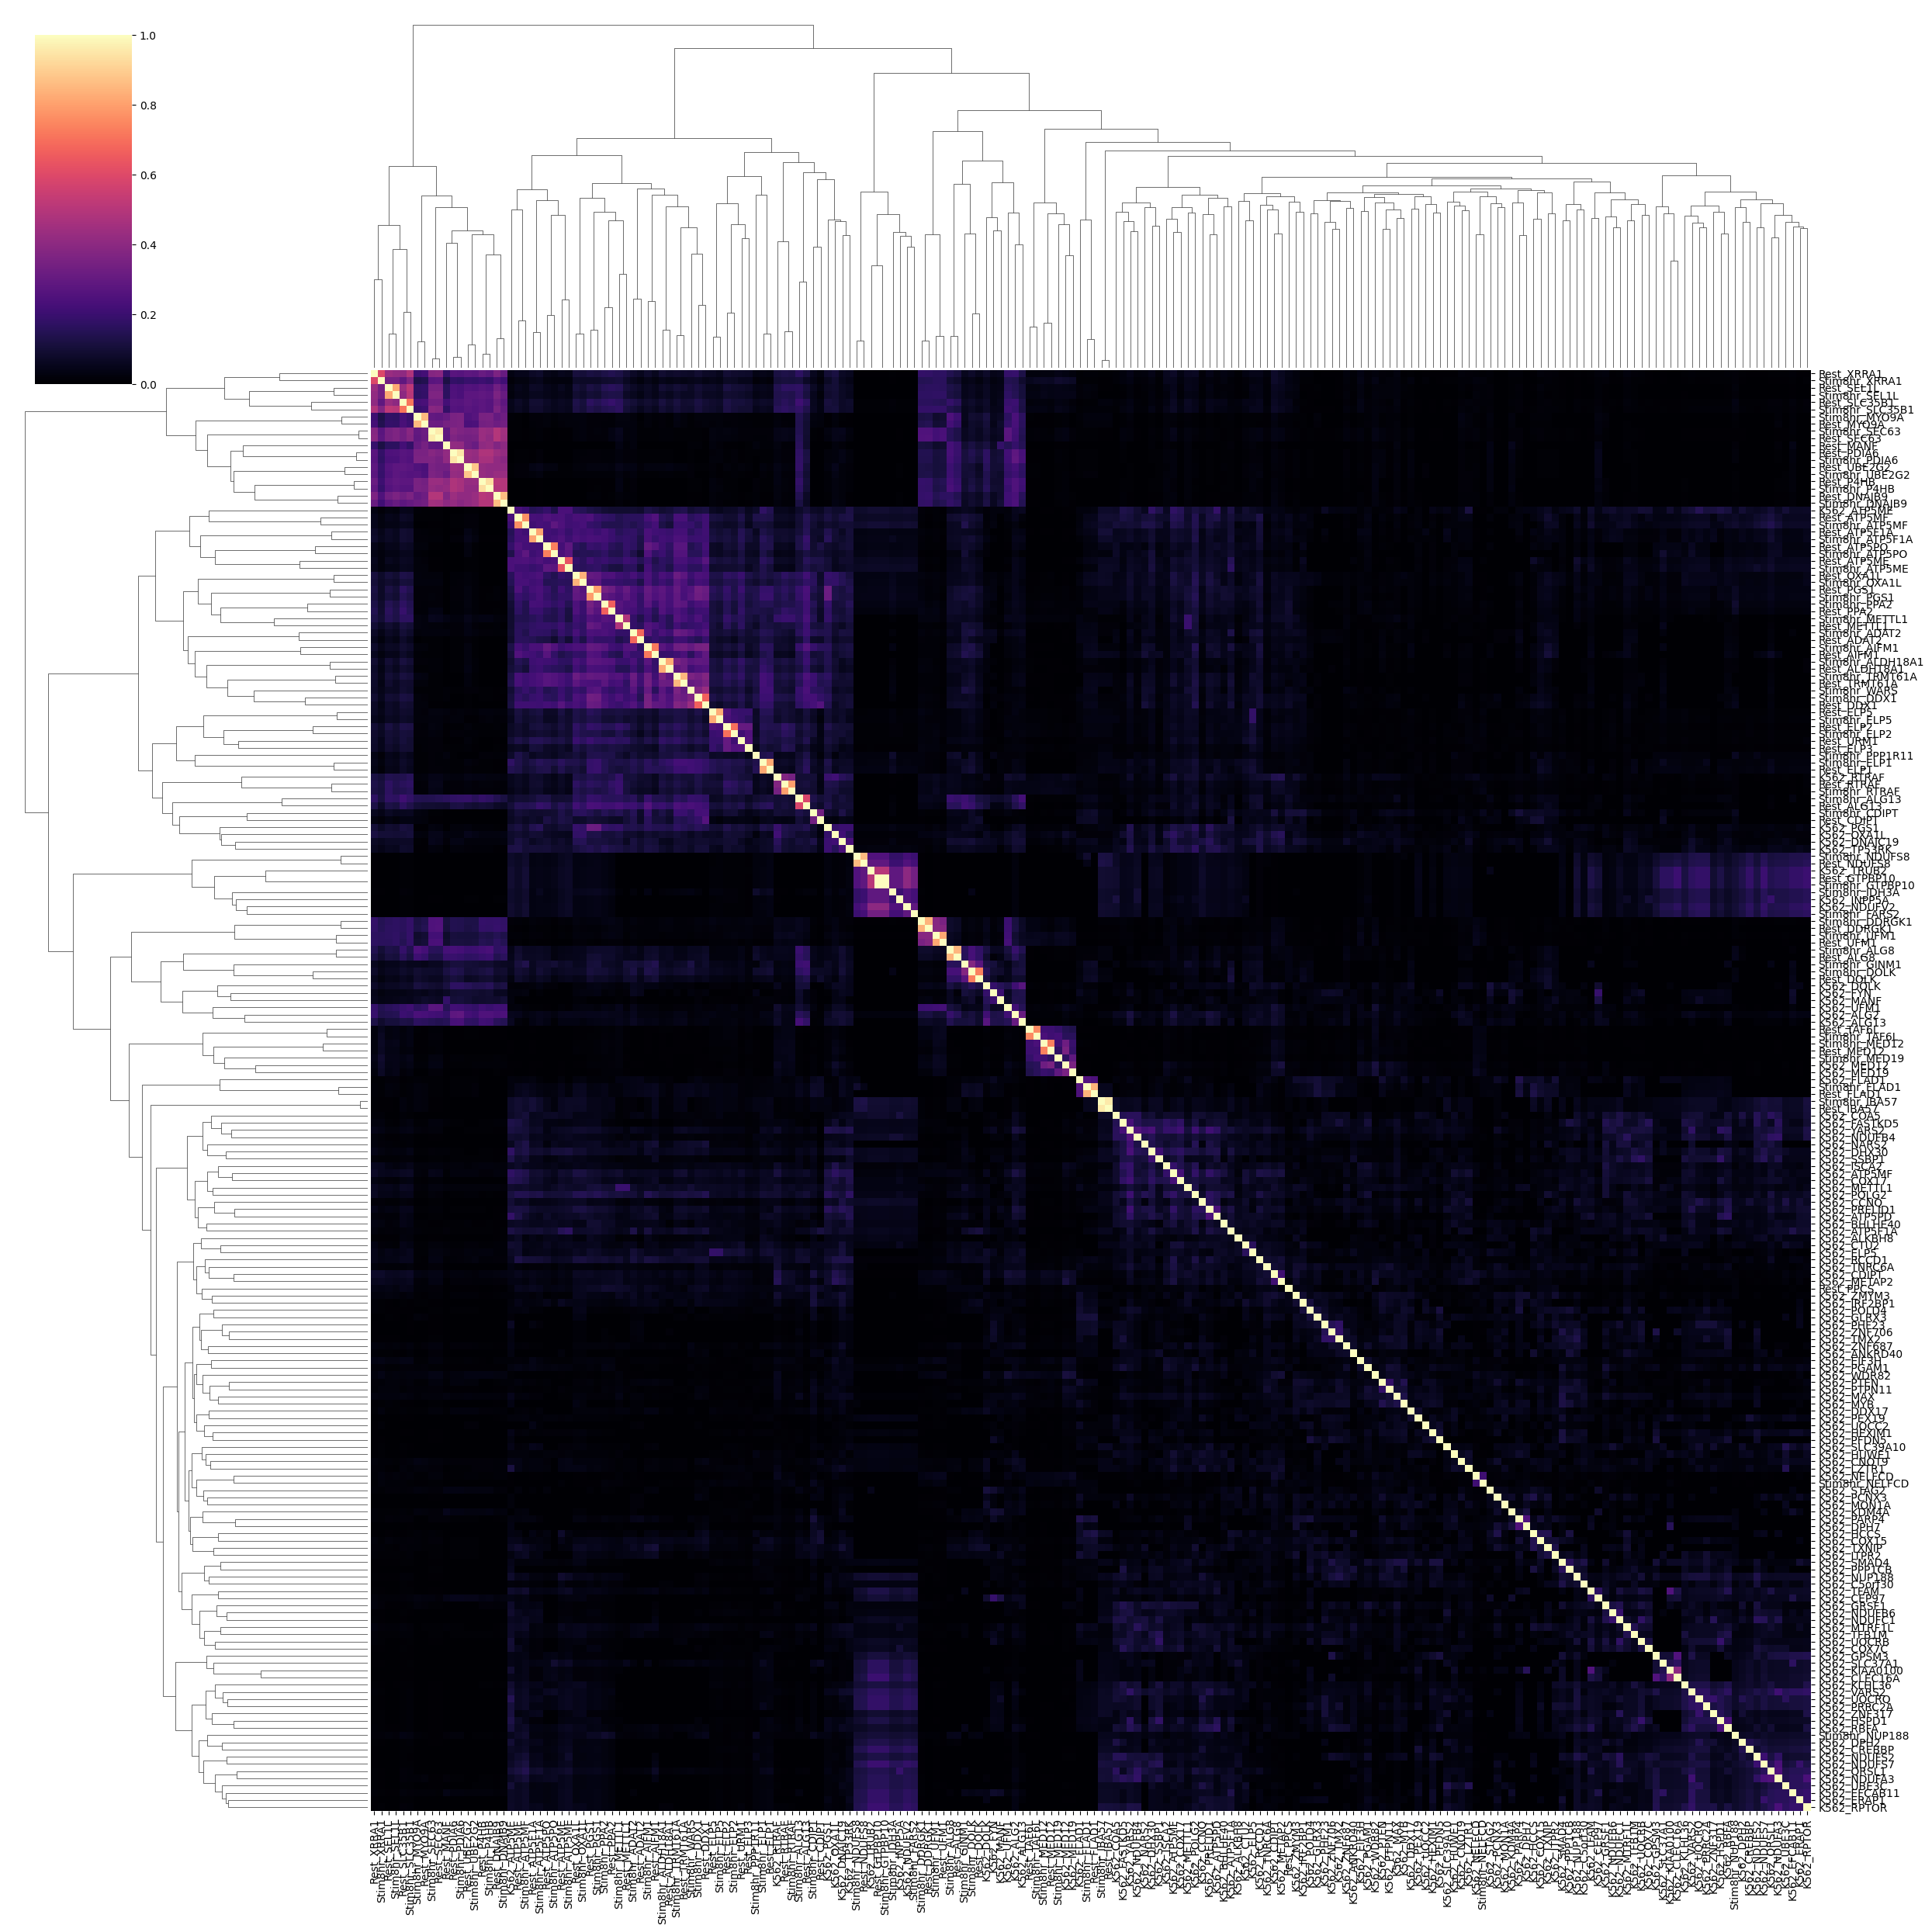

In [204]:
from scipy import cluster
# Filter by fraction of shared effects
filtered_data = similarity.loc[shared_effects.sum(1) > 5, shared_effects.sum(1) > 5]
order_perts = filtered_data.sum(0).sort_values(ascending=False)[0:200].index.tolist()
ordered_data = filtered_data.loc[order_perts, order_perts]

# First generate clustermap to get ordering
clustermap = sns.clustermap(
    ordered_data,
    method='complete', metric='euclidean',
    figsize=(25,25), 
    xticklabels=True, yticklabels=True,
    cmap='magma'
)

# Get the row and column ordering from the clustermap
row_order = clustermap.dendrogram_row.reordered_ind
col_order = clustermap.dendrogram_col.reordered_ind
reordered_data = ordered_data.iloc[row_order, col_order]